In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import GPy
import heatmap

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
# data = pd.read_csv("../data/final_data.csv.gz")
data

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df_ = data.to_dataframe().reset_index()
# df_ = 
df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
from sklearn.ensemble import RandomForestRegressor

def rf(X_train, y_train, X_test):

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    pred_y = rf.predict(X_test)
    
    return pred_y

2022-01-01 00:30:00	81.65207319819817


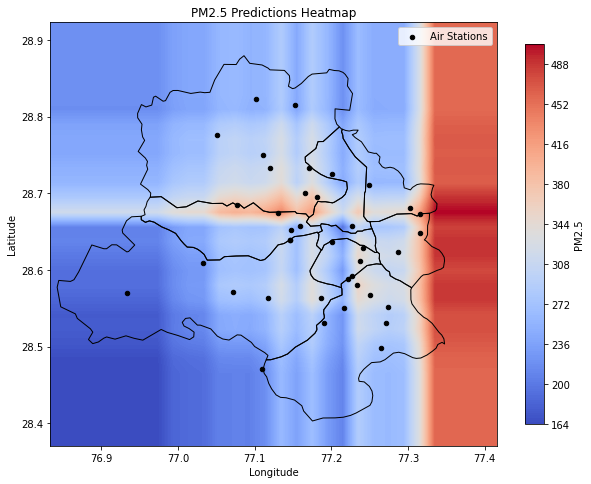

2022-02-01 00:30:00	47.59776548872185


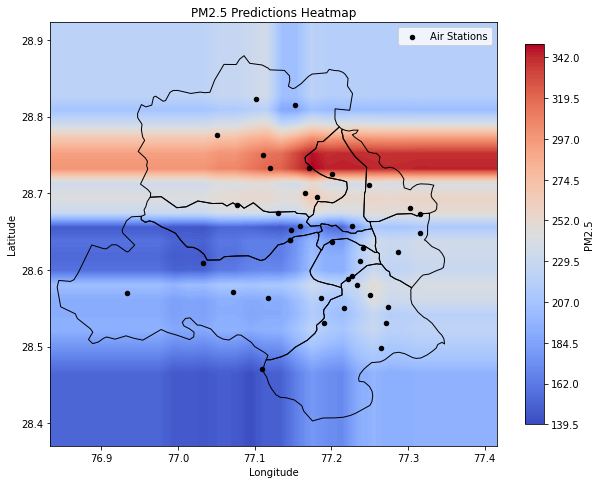

2022-03-01 00:30:00	23.451929755639117


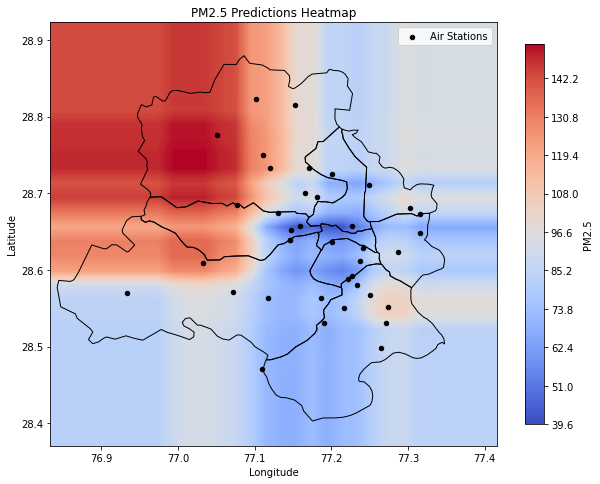

2022-04-01 00:30:00	30.142133918918933


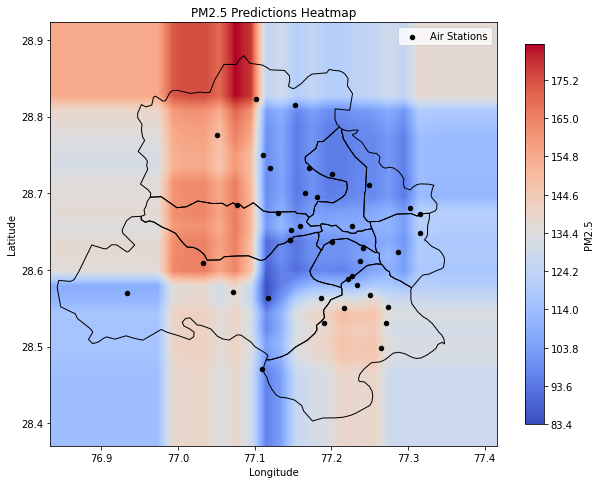

2022-05-01 00:30:00	42.1255962406015


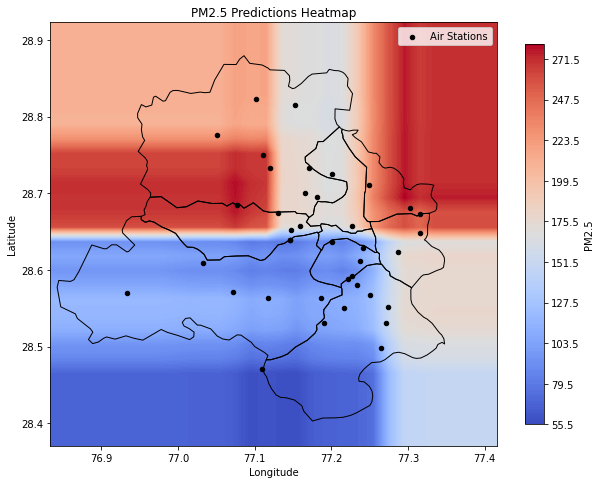

2022-06-01 00:30:00	43.89231240601504


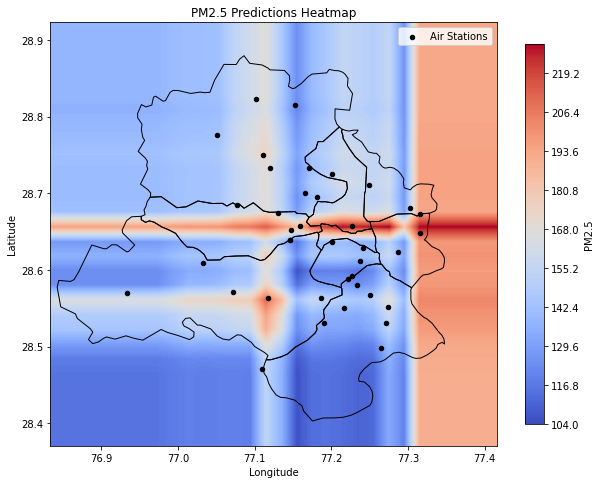

2022-07-01 00:30:00	8.668397058823526


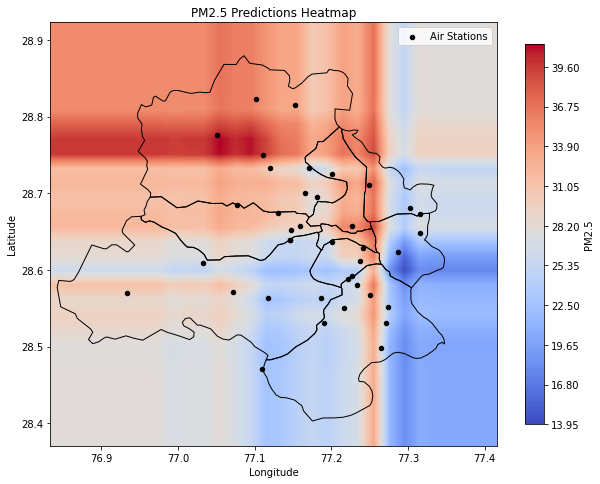

2022-08-01 00:30:00	11.133087709137708


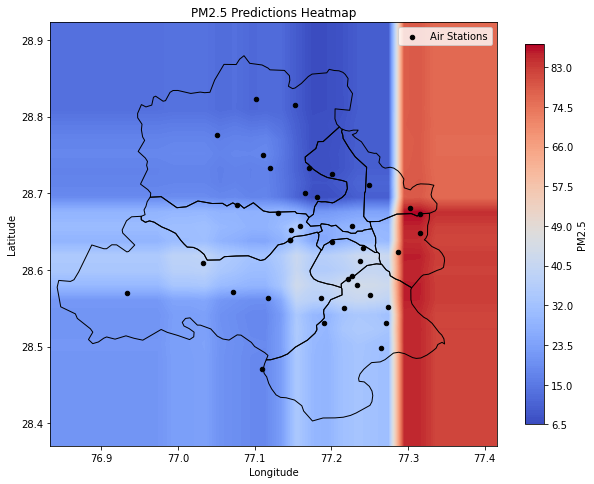

2022-09-01 00:30:00	13.284665047619047


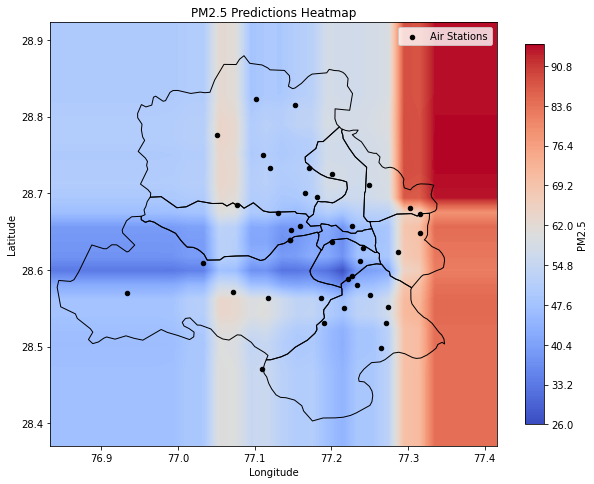

2022-10-01 00:30:00	20.798941142857142


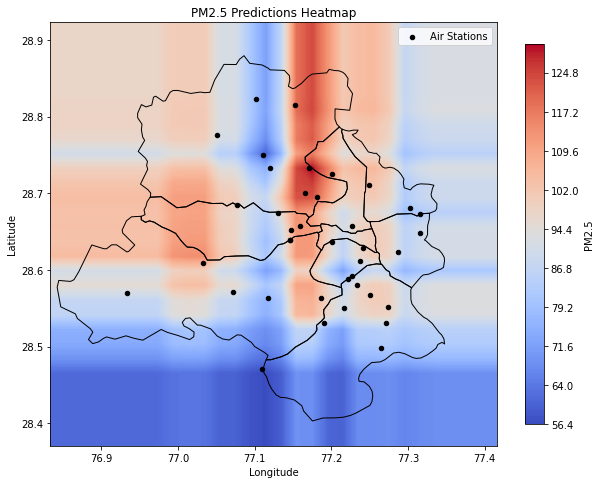

2022-11-01 00:30:00	81.78415719433714


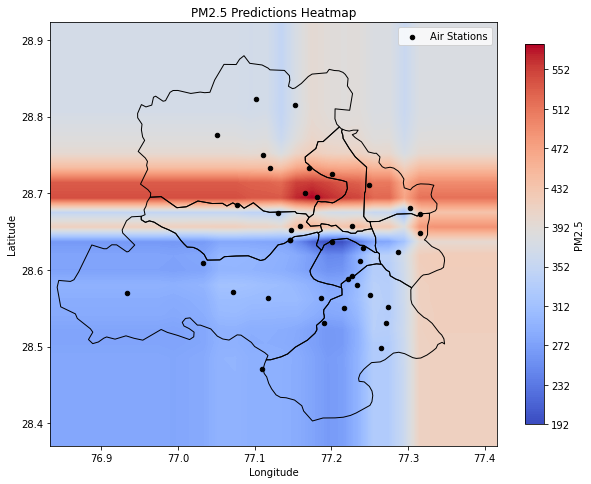

2022-12-01 00:30:00	58.67916207207205


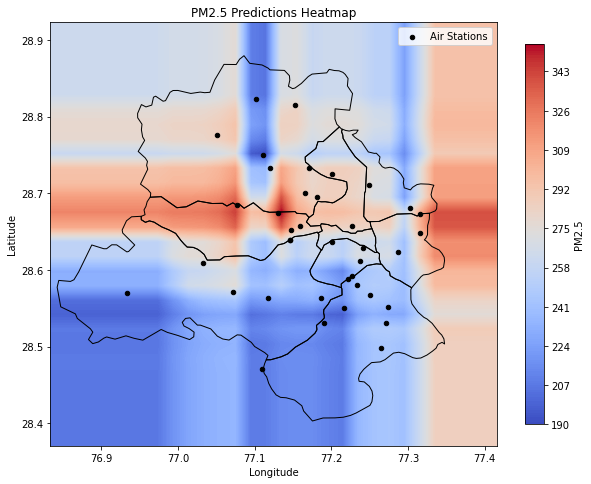

In [4]:
p = pd.date_range(start='2022-01-01 00:30:00', end='2022-12-01 00:30:00', freq = '1MS').to_frame(name='dates')
rf_rmse = []
rf_preds = []

for i in p['dates']:
    df = df_[df_["time"]==i]
    df = df.dropna(subset=["PM2.5"])
    print(i, end = '\t')
    rf_rmse_i = []
    
    #Leave One Out Cross Validation
    for station in df.station.unique():
        train = df[df['station'] != station]
        test = df[df['station'] == station]
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        pred = rf(X_train, y_train, X_test)
        rf_rmse_i.append(np.sqrt((y_test - pred)**2))
    
    #RMSE
    rf_rmse.append(np.mean(rf_rmse_i))
    print(rf_rmse[-1])
    
    #Heatmap
    latitudes = np.array(df['latitude'])
    longitudes = np.array(df['longitude'])
    g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
    g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
    
    train = df[['latitude', 'longitude', 'PM2.5']]
    test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten()})
    
    X_train = train[['latitude', 'longitude']]
    y_train = train['PM2.5']
    X_test = test[['latitude', 'longitude']]
    
    preds = rf(X_train, y_train, X_test)
    test['PM2.5'] = preds
    heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)

In [5]:
rf_rmse

[81.65207319819817,
 47.59776548872185,
 23.451929755639117,
 30.142133918918933,
 42.1255962406015,
 43.89231240601504,
 8.668397058823526,
 11.133087709137708,
 13.284665047619047,
 20.798941142857142,
 81.78415719433714,
 58.67916207207205]